# Imports

In [ ]:
import matplotlib
from google.colab import runtime

# Por defecto tiene matplotlib: 3.2.2
print('matplotlib: {}'.format(matplotlib.__version__))

if matplotlib.__version__ == '3.2.2':
    # Se necesita una versión > 3.5.1 que soporte float16 para pintar kanji
    !pip install -U matplotlib

    print('Stopping RUNTIME! Please run again.')
    quit()
    # https://twitter.com/GoogleColab/status/1569389018311426051

matplotlib: 3.7.0


In [ ]:
# track time of each cell
!pip install ipython-autotime
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
time: 508 µs (started: 2023-02-18 21:29:01 +00:00)


In [ ]:
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, subplots, show
import PIL as pil
import skimage.transform
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    confusion_matrix
)
from tensorflow import keras
from keras.layers import (
    Conv2D, MaxPool2D, Flatten, Dense,
    Dropout, Input, Concatenate, GlobalAveragePooling2D
)
from keras.models import Model
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from google.colab import drive

time: 2.9 s (started: 2023-02-18 21:29:01 +00:00)


In [ ]:
CHANNEL = 1
DATA_REPR = 'float32' # Antes era 'uint8'
NUM_CLASSES = 2965
ETL_DATASET = 'etl_9G'
DNN_NAME = 'DenseNet121'

USE_DATA_AUG = 'sin_DA' # o también con_DA
TYPE_IMG = 'regular' # o también inverted

TFM_PATH = '/content/gdrive/MyDrive/Master_IA/TFM/'
ROOT_PATH = TFM_PATH + 'datasets/'+ ETL_DATASET +'/uint32/imgs_{}/splits/'+ TYPE_IMG +'/'

print('versión Keras:', keras.__version__)

versión Keras: 2.11.0
time: 1.24 ms (started: 2023-02-18 21:29:03 +00:00)


In [ ]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
time: 1.8 s (started: 2023-02-18 21:29:03 +00:00)


# Funciones

In [ ]:
def load_images_for_training(DATA_REPR, PATH, TYPE_IMG):
    '''
    Load images for training and validation with their labels

    Args:

    - DATA_REPR: Representation of numpy data. Ex: uint8, float32
    - ROOT_PATH: Path in Google Drive where imgs and labels are stored

    Output:
    - np arrays for training and validation images
    '''
    if TYPE_IMG == 'regular':
        train_name_img = 'train_imgs_9G.npz'
        train_name_labels = 'train_labels_9G.npz'
        val_name_img = 'val_imgs_9G.npz'
        val_name_labels = 'val_labels_9G.npz'
    elif TYPE_IMG == 'inverted':
        train_name_img = 'train_inv_imgs_9G.npz'
        train_name_labels = 'train_inv_labels_9G.npz'
        val_name_img = 'val_inv_imgs_9G.npz'
        val_name_labels = 'val_inv_labels_9G.npz'

    train_images = np.load(PATH+train_name_img)['arr_0']
    train_labels = np.load(PATH+train_name_labels)['arr_0'].astype(DATA_REPR)

    val_images = np.load(PATH+val_name_img)['arr_0']
    val_labels = np.load(PATH+val_name_labels)['arr_0'].astype(DATA_REPR)

    return train_images, train_labels, val_images, val_labels


def load_test_images(DATA_REPR, PATH, TYPE_IMG):
    '''
    Load images for training and validation with their labels

    Args:

    - DATA_REPR: Representation of numpy data. Ex: uint8, float32
    - ROOT_PATH: Path in Google Drive where imgs and labels are stored

    Output:
    - np arrays for testing images
    '''

    if TYPE_IMG == 'regular':
        test_name_img = 'test_imgs_9G.npz'
        test_name_labels = 'test_labels_9G.npz'
    elif TYPE_IMG == 'inverted':
        test_name_img = 'test_inv_imgs_9G.npz'
        test_name_labels = 'test_inv_labels_9G.npz'

    test_images = np.load(PATH+test_name_img)['arr_0']
    test_labels = np.load(PATH+test_name_labels)['arr_0'].astype(DATA_REPR)

    return test_images, test_labels


def create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL):

    image_input = Input(shape=(WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL))
    img_conc = Concatenate()([image_input, image_input, image_input])

    m_DenseNet121_9G = keras.applications.DenseNet121(
        include_top=False,
        input_tensor=img_conc,
        weights='imagenet',
    )

    last_layer = m_DenseNet121_9G.layers[-1].output
    x = GlobalAveragePooling2D()(last_layer)
    out = Dense(NUM_CLASSES, activation='softmax', name='predictions')(x)
    custom_model = Model(image_input, out)

    # freeze all the layers except the 2 newly added layers
    for layer in custom_model.layers[:-2]:
        layer.trainable = False

    return custom_model


def train_model(custom_model, train_images, train_labels, val_images, val_labels):

    callback = EarlyStopping(
        monitor='val_sparse_categorical_accuracy',
        patience=5,
        verbose=1
    )

    custom_model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=Adam(learning_rate=0.0001),
        metrics=["sparse_categorical_accuracy"]
    )

    history = custom_model.fit(
        train_images,
        train_labels,
        validation_data=(val_images, val_labels),
        epochs= 50, # en 2022 usé 20 epochs
        callbacks = [callback],
        # verbose = 1,
        # batch_size=32
    )

    print('--- Iterations ended ---')
    print()
    print()

    return history


def show_metrics(custom_model, test_images, test_labels):
    test_loss, test_accuracy = custom_model.evaluate(test_images, test_labels)
    y_pred = np.argmax(custom_model.predict(test_images), axis=1)

    print("*********************************************************************************************************************************")
    print()
    print("- Test Accuracy:", test_accuracy)
    print("- Test Loss:", test_loss)
    print("- time: ")
    print("- F1 score:", f1_score(test_labels, y_pred, average='weighted'))
    print("- Precision score:", precision_score(test_labels, y_pred, average='weighted'))
    print("- Recall: ", recall_score(test_labels, y_pred, average='weighted'))
    print("- Epoch: ")
    print("*********************************************************************************************************************************")


def plot_loss(history):
    pd.DataFrame(history.history).plot(figsize=(7,5))
    plt.grid(True)
    plt.gca().set_ylim(0,2) # usualmente 0,5
    plt.show()


def show_history(history):
    #-----------------------------------------------------------
    # Recuperar una lista de resultados de la lista de datos de los conjuntos de entrenamiento y pruebas para cada epoch de entrenamiento
    #-----------------------------------------------------------

    acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    #------------------------------------------------
    # Imprimir la precisión del entrenamiento y validación por epoch
    #------------------------------------------------
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Precisión de entrenamiento y validación')
    plt.legend()
    plt.grid()
    plt.figure()

    #------------------------------------------------
    # Imprimir la perdida de entrenamiento y validación por epoch
    #------------------------------------------------
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Perdida de entrenamiento y validación')
    plt.legend()
    plt.grid()
    plt.show()


time: 6.15 ms (started: 2023-02-18 21:29:05 +00:00)


# Imgs 64x64

- Test Accuracy: 0.6466273069381714
- Test Loss: 1.7320784330368042
- time: 3h 39min 19s
- F1 score: 0.6474396728971584
- Precision score: 0.6691891353252659
- Recall:  0.6466273187183811
- Epoch: 50/50

## Cargar la imágenes

In [ ]:
SIZE = 64  # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
PATH = ROOT_PATH.format(SIZE)

time: 556 µs (started: 2023-02-16 16:34:53 +00:00)


In [ ]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 28.7 s (started: 2023-02-16 16:34:53 +00:00)


In [ ]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()
print()

- train images: (444750, 64, 64, 1) and labels: (444750,)

- val images: (88950, 64, 64, 1) and labels: (88950,)


time: 1.27 ms (started: 2023-02-16 16:35:22 +00:00)


## Preparar el modelo

In [ ]:
custom_model = create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL)

29084464/29084464 [==============================] - 0s 0us/step
time: 7.79 s (started: 2023-02-16 16:35:22 +00:00)


In [ ]:
print(custom_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 64, 64, 3)    0           ['input_1[0][0]',                
                                                                  'input_1[0][0]',                
                                                                  'input_1[0][0]']                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)   0           ['concatenate[0][0]']            
                                                                                              

## Entrenar modelo

In [ ]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
13899/13899 [==============================] - 338s 23ms/step - loss: 6.1635 - sparse_categorical_accuracy: 0.1119 - val_loss: 5.2047 - val_sparse_categorical_accuracy: 0.2083
Epoch 2/50
13899/13899 [==============================] - 314s 23ms/step - loss: 4.5658 - sparse_categorical_accuracy: 0.2986 - val_loss: 4.2843 - val_sparse_categorical_accuracy: 0.3229
Epoch 3/50
13899/13899 [==============================] - 308s 22ms/step - loss: 3.7736 - sparse_categorical_accuracy: 0.4021 - val_loss: 3.7319 - val_sparse_categorical_accuracy: 0.3880
Epoch 4/50
13899/13899 [==============================] - 261s 19ms/step - loss: 3.2582 - sparse_categorical_accuracy: 0.4681 - val_loss: 3.3573 - val_sparse_categorical_accuracy: 0.4362
Epoch 5/50
13899/13899 [==============================] - 262s 19ms/step - loss: 2.8898 - sparse_categorical_accuracy: 0.5161 - val_loss: 3.0856 - val_sparse_categorical_accuracy: 0.4674
Epoch 6/50
13899/13899 [==============================] - 262s 19

In [ ]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 3.96 s (started: 2023-02-16 20:14:52 +00:00)


In [ ]:
show_metrics(custom_model, test_images, test_labels)

1854/1854 [==============================] - 29s 15ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.6466273069381714
- Test Loss: 1.7320784330368042
- time: 
- F1 score: 0.6474396728971584
- Precision score: 0.6691891353252659
- Recall:  0.6466273187183811
- Epoch: 
*********************************************************************************************************************************
time: 1min 2s (started: 2023-02-16 20:14:56 +00:00)


## Graficando

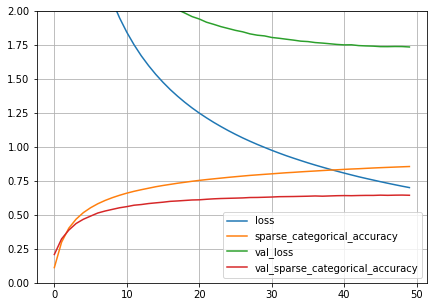

time: 305 ms (started: 2023-02-16 20:15:59 +00:00)


In [ ]:
plot_loss(history)

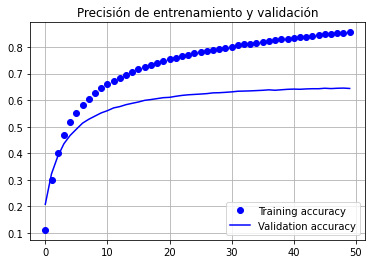

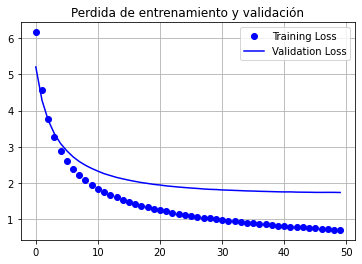

time: 619 ms (started: 2023-02-16 20:15:59 +00:00)


In [ ]:
show_history(history)

In [ ]:
# Por default lo guarda es en el mismo Google Colab's notebook
custom_model.save(WEIGHTS_PATH)
print('------ Model Saved -------')

------ Model Saved -------
time: 2.86 s (started: 2023-02-16 20:16:00 +00:00)


# Imgs 96x96

- Test Accuracy: 0.6943001747131348
- Test Loss: 1.533421277999878
- time: 4h 3s
- F1 score: 0.6946611648574387
- Precision score: 0.7135890433102341
- Recall:  0.6943001686340641
- Epoch: 50/50

## Cargar las imágenes

In [ ]:
SIZE = 96  # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
PATH = ROOT_PATH.format(SIZE)

time: 532 µs (started: 2023-02-16 20:16:02 +00:00)


In [ ]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 56 s (started: 2023-02-16 20:16:02 +00:00)


In [ ]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()

- train images: (444750, 96, 96, 1) and labels: (444750,)

- val images: (88950, 96, 96, 1) and labels: (88950,)

time: 1.08 ms (started: 2023-02-16 20:16:58 +00:00)


## Preparar el modelo

In [ ]:
custom_model = create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL)

time: 2.93 s (started: 2023-02-16 20:16:58 +00:00)


In [ ]:
print(custom_model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 96, 96, 1)]  0           []                               
                                                                                                  
 concatenate_1 (Concatenate)    (None, 96, 96, 3)    0           ['input_2[0][0]',                
                                                                  'input_2[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 102, 102, 3)  0          ['concatenate_1[0][0]']          
 D)                                                                                         

## Entrenar modelo

In [ ]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
13899/13899 [==============================] - 296s 21ms/step - loss: 6.4493 - sparse_categorical_accuracy: 0.0966 - val_loss: 5.5811 - val_sparse_categorical_accuracy: 0.1869
Epoch 2/50
13899/13899 [==============================] - 286s 21ms/step - loss: 5.0005 - sparse_categorical_accuracy: 0.2671 - val_loss: 4.6902 - val_sparse_categorical_accuracy: 0.2967
Epoch 3/50
13899/13899 [==============================] - 286s 21ms/step - loss: 4.2272 - sparse_categorical_accuracy: 0.3691 - val_loss: 4.1198 - val_sparse_categorical_accuracy: 0.3646
Epoch 4/50
13899/13899 [==============================] - 288s 21ms/step - loss: 3.6949 - sparse_categorical_accuracy: 0.4383 - val_loss: 3.7102 - val_sparse_categorical_accuracy: 0.4154
Epoch 5/50
13899/13899 [==============================] - 287s 21ms/step - loss: 3.2986 - sparse_categorical_accuracy: 0.4903 - val_loss: 3.3981 - val_sparse_categorical_accuracy: 0.4543
Epoch 6/50
13899/13899 [==============================] - 286s 21

In [ ]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 7.78 s (started: 2023-02-17 00:17:07 +00:00)


In [ ]:
show_metrics(custom_model, test_images, test_labels)

1854/1854 [==============================] - 33s 17ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.6943001747131348
- Test Loss: 1.533421277999878
- time: 
- F1 score: 0.6946611648574387
- Precision score: 0.7135890433102341
- Recall:  0.6943001686340641
- Epoch: 
*********************************************************************************************************************************
time: 1min 12s (started: 2023-02-17 00:17:15 +00:00)


## Graficando

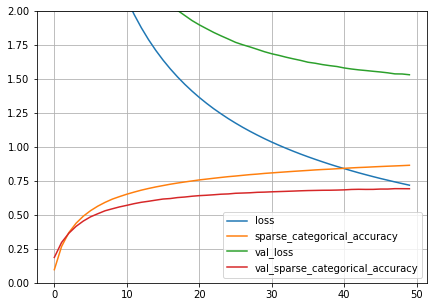

time: 205 ms (started: 2023-02-17 00:18:27 +00:00)


In [ ]:
plot_loss(history)

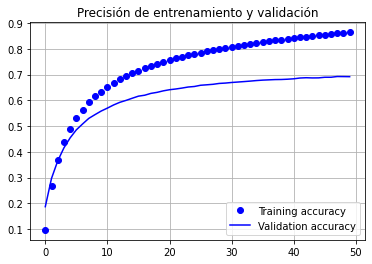

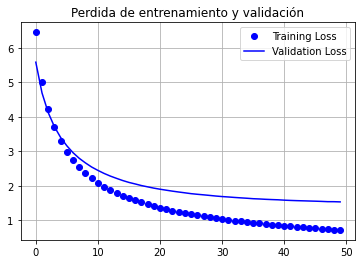

time: 380 ms (started: 2023-02-17 00:18:27 +00:00)


In [ ]:
show_history(history)

In [ ]:
# Por default lo guarda es en el mismo Google Colab's notebook
custom_model.save(WEIGHTS_PATH)
print('------ Model Saved -------')

------ Model Saved -------
time: 923 ms (started: 2023-02-17 00:18:28 +00:00)


# Imgs 112x112

- Test Accuracy: 0.7281956076622009
- Test Loss: 1.296411395072937
- time: 4h 22min 41s
- F1 score: 0.7289269509729073
- Precision score: 0.7449810467125975
- Recall:  0.7281956155143339
- Epoch: 50/50 


## Cargar imágenes

In [ ]:
SIZE = 112  # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
PATH = ROOT_PATH.format(SIZE)

time: 772 µs (started: 2023-02-17 18:07:42 +00:00)


In [ ]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 1min 23s (started: 2023-02-17 00:25:47 +00:00)


In [ ]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()

- train images: (444750, 112, 112, 1) and labels: (444750,)

- val images: (88950, 112, 112, 1) and labels: (88950,)

time: 1.11 ms (started: 2023-02-17 00:27:10 +00:00)


## Preparar el modelo

In [ ]:
custom_model = create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL)

29084464/29084464 [==============================] - 2s 0us/step
time: 9.15 s (started: 2023-02-17 00:27:10 +00:00)


In [ ]:
print(custom_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 112, 112, 1  0           []                               
                                )]                                                                
                                                                                                  
 concatenate (Concatenate)      (None, 112, 112, 3)  0           ['input_1[0][0]',                
                                                                  'input_1[0][0]',                
                                                                  'input_1[0][0]']                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 118, 118, 3)  0          ['concatenate[0][0]']        

## Entrenar modelo


In [ ]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
13899/13899 [==============================] - 326s 22ms/step - loss: 6.1028 - sparse_categorical_accuracy: 0.1357 - val_loss: 5.0903 - val_sparse_categorical_accuracy: 0.2535
Epoch 2/50
13899/13899 [==============================] - 315s 23ms/step - loss: 4.4500 - sparse_categorical_accuracy: 0.3433 - val_loss: 4.1136 - val_sparse_categorical_accuracy: 0.3720
Epoch 3/50
13899/13899 [==============================] - 319s 23ms/step - loss: 3.6248 - sparse_categorical_accuracy: 0.4509 - val_loss: 3.5222 - val_sparse_categorical_accuracy: 0.4445
Epoch 4/50
13899/13899 [==============================] - 318s 23ms/step - loss: 3.0863 - sparse_categorical_accuracy: 0.5214 - val_loss: 3.1170 - val_sparse_categorical_accuracy: 0.4932
Epoch 5/50
13899/13899 [==============================] - 308s 22ms/step - loss: 2.7015 - sparse_categorical_accuracy: 0.5715 - val_loss: 2.8227 - val_sparse_categorical_accuracy: 0.5270
Epoch 6/50
13899/13899 [==============================] - 304s 22

## Métricas


In [ ]:
# Cargar modelo
MODEL_NAME = f'model_{DNN_NAME.lower()}_etl9_imgs{SIZE}_' + TYPE_IMG +'.h5'
WEIGHTS_PATH = TFM_PATH + 'notebooks/arqs_2023/' \
                + DNN_NAME + f'/weights_{DNN_NAME.lower()}/' \
                + USE_DATA_AUG +'/'+ TYPE_IMG +'/etl9G' + MODEL_NAME

print(WEIGHTS_PATH)

custom_model = keras.models.load_model(WEIGHTS_PATH)

/content/gdrive/MyDrive/Master_IA/TFM/notebooks/arqs_2023/DenseNet121/weights_densenet121/sin_DA/regular/etl9Gmodel_densenet121_etl9_imgs112_regular.h5
time: 10.6 s (started: 2023-02-17 18:07:46 +00:00)


In [ ]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 11.2 s (started: 2023-02-17 18:07:56 +00:00)


In [ ]:
show_metrics(custom_model, test_images, test_labels)

1854/1854 [==============================] - 31s 16ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.7281956076622009
- Test Loss: 1.296411395072937
- time: 
- F1 score: 0.7289269509729073
- Precision score: 0.7449810467125975
- Recall:  0.7281956155143339
- Epoch: 
*********************************************************************************************************************************
time: 1min 21s (started: 2023-02-17 18:08:07 +00:00)


## Graficando

In [ ]:
plot_loss(history)

In [ ]:
show_history(history)

In [ ]:
# Por default lo guarda es en el mismo Google Colab's notebook
custom_model.save(WEIGHTS_PATH)
print('------ Model Saved -------')

# Imgs 127x127

- Test Accuracy: 0.7344434857368469
- Test Loss: 1.262024164199829
- time: 3h 41min 15s
- F1 score: 0.7356785357377849
- Precision score: 0.7490319057612047
- Recall:  0.7344435075885328
- Epoch: 50/50

## Cargar imágenes

In [ ]:
SIZE = 127  # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
ROOT_PATH = TFM_PATH + 'datasets/'+ ETL_DATASET +'/uint32/imgs_{}/splits/'+ TYPE_IMG +'_v2/'
PATH = ROOT_PATH.format(SIZE)

print(PATH)

MODEL_NAME = f'model_{DNN_NAME.lower()}_etl9_imgs{SIZE}_' + TYPE_IMG +'.h5'
WEIGHTS_PATH = TFM_PATH + 'notebooks/arqs_2023/' \
            + DNN_NAME + f'/weights_{DNN_NAME.lower()}/' \
            + USE_DATA_AUG +'/'+ TYPE_IMG +'/' + MODEL_NAME

print('Weights path:', WEIGHTS_PATH)

/content/gdrive/MyDrive/Master_IA/TFM/datasets/etl_9G/uint32/imgs_127/splits/regular_v2/
Weights path: /content/gdrive/MyDrive/Master_IA/TFM/notebooks/arqs_2023/DenseNet121/weights_densenet121/sin_DA/regular/model_densenet121_etl9_imgs127_regular.h5
time: 1.42 ms (started: 2023-02-18 21:29:06 +00:00)


In [ ]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 1min 27s (started: 2023-02-18 17:44:55 +00:00)


In [ ]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()

- train images: (355800, 127, 127, 1) and labels: (355800,)

- val images: (118600, 127, 127, 1) and labels: (118600,)

time: 1.46 ms (started: 2023-02-18 17:46:22 +00:00)


## Preparar el modelo

In [ ]:
custom_model = create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL)

29084464/29084464 [==============================] - 0s 0us/step
time: 6.85 s (started: 2023-02-18 17:46:22 +00:00)


In [ ]:
print(custom_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 127, 127, 1  0           []                               
                                )]                                                                
                                                                                                  
 concatenate (Concatenate)      (None, 127, 127, 3)  0           ['input_1[0][0]',                
                                                                  'input_1[0][0]',                
                                                                  'input_1[0][0]']                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 133, 133, 3)  0          ['concatenate[0][0]']        

## Entrenar modelo

In [ ]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
11119/11119 [==============================] - 288s 25ms/step - loss: 6.4056 - sparse_categorical_accuracy: 0.1069 - val_loss: 5.4818 - val_sparse_categorical_accuracy: 0.2157
Epoch 2/50
11119/11119 [==============================] - 269s 24ms/step - loss: 4.8560 - sparse_categorical_accuracy: 0.3063 - val_loss: 4.5285 - val_sparse_categorical_accuracy: 0.3365
Epoch 3/50
11119/11119 [==============================] - 267s 24ms/step - loss: 4.0296 - sparse_categorical_accuracy: 0.4176 - val_loss: 3.9185 - val_sparse_categorical_accuracy: 0.4089
Epoch 4/50
11119/11119 [==============================] - 265s 24ms/step - loss: 3.4630 - sparse_categorical_accuracy: 0.4921 - val_loss: 3.4847 - val_sparse_categorical_accuracy: 0.4627
Epoch 5/50
11119/11119 [==============================] - 266s 24ms/step - loss: 3.0438 - sparse_categorical_accuracy: 0.5467 - val_loss: 3.1606 - val_sparse_categorical_accuracy: 0.5014
Epoch 6/50
11119/11119 [==============================] - 264s 24

## Graficando

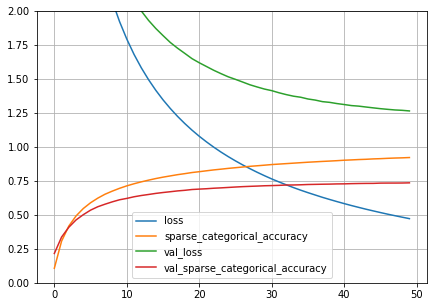

time: 402 ms (started: 2023-02-18 21:27:47 +00:00)


In [ ]:
plot_loss(history)

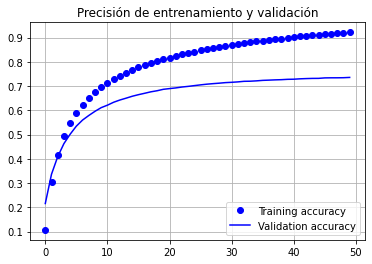

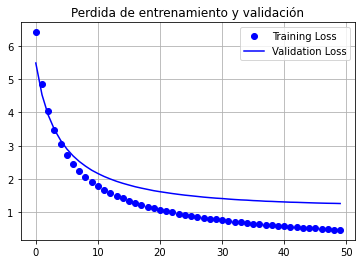

time: 382 ms (started: 2023-02-18 21:27:47 +00:00)


In [ ]:
show_history(history)

In [ ]:
# Por default lo guarda es en el mismo Google Colab's notebook
custom_model.save(WEIGHTS_PATH)
print('------ Model Saved -------')

------ Model Saved -------
time: 1.74 s (started: 2023-02-18 21:27:47 +00:00)


## Métricas

In [ ]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 22.1 s (started: 2023-02-18 21:29:30 +00:00)


In [ ]:
# Cargar modelo
custom_model = keras.models.load_model(WEIGHTS_PATH)

time: 6.46 s (started: 2023-02-18 21:29:52 +00:00)


In [ ]:
show_metrics(custom_model, test_images, test_labels)

3707/3707 [==============================] - 63s 17ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.7344434857368469
- Test Loss: 1.262024164199829
- time: 
- F1 score: 0.7356785357377849
- Precision score: 0.7490319057612047
- Recall:  0.7344435075885328
- Epoch: 
*********************************************************************************************************************************
time: 2min 36s (started: 2023-02-18 21:29:59 +00:00)


In [ ]:
runtime.unassign()

#quit()

time: 175 ms (started: 2023-02-18 21:32:35 +00:00)
